In [1]:
import pandas as pd
from nltk.corpus import stopwords
from tools import *
import nltk.data
import numpy as np
from collections import Counter
import nltk
import gensim
import spacy
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns
import warnings 

#from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
data = pd.read_csv('data/signal_token.csv')
sent_transform = lambda x: [[j.strip("\'") for j in i.split("', '")] for i in 
                             x.strip('[|]').split("'], ['")]
data['sent_token'] = data['sent_token'].apply(sent_transform)
data['word_token'] = data['word_token'].apply(lambda x: x.strip("[|]|'").split("', '"))
words_W2V = gensim.models.word2vec.Word2Vec.load('sigTotal_WORD2Vec')
data['reduced_tokens'] = data['word_token'].apply(lambda x:
                                                 [i for i in x if i in words_W2V])

In [3]:
target_word = dict()
target_word['economy']  = ['business', 'finance',
                           'enterprise', 'tax', 'market',
                           'trade', 'monetary', 'tariff', 'bank']

target_word['religion'] = ['christian', 'church', 'religion', 'god', 
                           'baptist', 'bible', 'protestant', 'catholic',
                           'religious']

target_word['defense']  = ['communist', 'defense', 'army', 'terrorism', 
                           'nuclear', 'islam', 'military',
                           'regime', 'troop', 'submarine', 'iran']

target_word['congress'] = ['senator', 'congress', 'vote', 'election']

target_word['health']   = ['health', 'medicine', 'medication', 
                           'hospital', 'medicare', 'medicaid']

target_word['woman'] = ['baby', 'abortion', 'pregnant', 'parenthood', 'childbearing']

target_word['gun']  = ['gun', 'firearm', 'shootings', 'shooting']

target_word['tech'] = ['nasa', 'cyber', 'cybersecurity','scientist', 'hacker']

target_word['environment'] = ['environmental', 'conservation', 'renewable', 'energy',
                              'resort', 'pollution']

target_word['lgbt'] = ['homosexual', 'gay', 'lgbt', 'sexual',
                       'transgender', 'lgbtq']

target_word['immigration'] = ['immigrants', 'immigration', 'border', 'mexican',
                              'crossing', 'deportation']

target_word['school'] = ['tenure', 'school', 'tuition', 'student', 'teacher']

In [4]:
axg = pd.DataFrame()
for key in target_word:
    lst = ", ".join(target_word[key])
    axg[key] = [lst]
#axg.T.to_csv('target_word.csv')

In [5]:
taggedDocs = []
for index, row in data.iterrows():

    docKeywords = []
    for topic in target_word:
        for w in target_word[topic]:
            if w in row['word_token']:
                docKeywords.append(topic)
    docKeywords.append(index)
    
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['word_token'], 
                                                            tags = docKeywords))
dataD2V = gensim.models.doc2vec.Doc2Vec(taggedDocs, vector_size = 100)

In [6]:
for key in target_word:
    sim = [cosine_similarity(dataD2V.docvecs[i].reshape(1, -1), 
                             dataD2V[key].reshape(1, -1))[0][0] for i in data.index]
    data[key] = sim

In [33]:
names = list(target_word.keys())
df_distance = np.zeros([len(names),len(names)])
for i in range(len(names)):
    for j in range(len(names)):
        df_distance[i][j] = cosine_similarity(dataD2V.docvecs[names[i]].reshape(1, -1), 
                            dataD2V.docvecs[names[j]].reshape(1, -1))[0][0]

df_distance = pd.DataFrame(df_distance)
df_distance.columns = names
df_distance.index = names

In [32]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

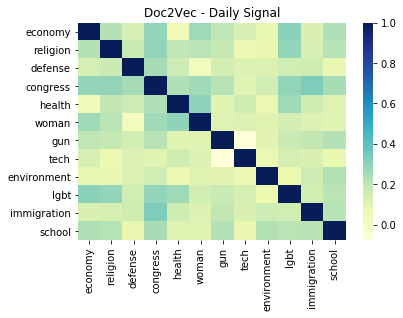

In [34]:
sns.heatmap(df_distance, cmap="YlGnBu")
plt.title('Doc2Vec - Daily Signal')
plt.show()

In [28]:
data['topic'] = data[names].apply(lambda x: names[list(x).index(sorted(x)[-1])] 
                               if sorted(x)[-1] > 0.1 else "", axis=1)

In [37]:
taggedDocs[10][1]

['economy', 'congress', 'congress', 10]

In [36]:
print(data['text'][10])

Before the House approved a sweeping union-boss wish list that attempts to send workers back into the 20th century, AFL-CIO union leader Richard Trumka warned lawmakers that “Those who would oppose, delay, or derail this legislation, do not ask us—do not ask the labor movement—for a dollar or a door knock.
We won’t be coming.”
In other words, if lawmakers didn’t vote for legislation that eliminates jobs that aren’t easily unionized and forces workers to pay fees to unions they do not want to belong to (along with many other union wish list items), unions would refuse to use their money and resources to help them get reelected.
In the 1950s, more than 30% of workers were union members.
Now, only 6.2% of private sector workers belong to unions.
In states where workers have the right to choose whether to join a union, only 2% to 5% of workers belong to unions.
And much of the reason can be traced to efforts such
as this.
When unions fought for safer working conditions and fairer wages—whe

In [35]:
data[data['topic']=='lgbt']

,ind,category,Year,text,sent_token,word_token,reduced_tokens,economy,religion,defense,congress,health,woman,gun,tech,environment,lgbt,immigration,school,topic
10,sig10,economy,2020,Before the House approved a sweeping union-bos...,"[[house, approve, sweep, union, boss, wish, li...","[house, approve, sweep, union, boss, wish, lis...","[house, approve, sweep, union, boss, wish, lis...",0.046342,0.114239,0.073032,0.142777,0.102334,0.204025,0.072062,0.078093,0.102810,0.286448,0.168173,0.083684,lgbt
53,sig53,economy,2019,"In a segment that aired Friday night, Fox News...","[[segment, air, friday, night, fox, news, chan...","[segment, air, friday, night, fox, news, chann...","[segment, air, friday, night, fox, news, chann...",-0.214563,0.183219,-0.013385,-0.144689,-0.054405,0.002236,-0.038301,0.027569,0.124223,0.192017,0.032540,0.012220,lgbt
64,sig64,economy,2019,As a woman who gave birth to six children and ...,"[[woman, give, birth, child], [raise, find, co...","[woman, give, birth, child, raise, find, compa...","[woman, give, birth, child, raise, find, compa...",0.080463,0.066422,0.121527,0.103382,0.111130,0.094918,0.029166,-0.053407,0.061267,0.161143,0.102851,0.090435,lgbt
65,sig65,economy,2019,"“To me, capitalism is irredeemable,” Rep. Alex...","[[capitalism, irredeemable, rep, alexandria, o...","[capitalism, irredeemable, rep, alexandria, oc...","[capitalism, irredeemable, rep, alexandria, oc...",0.010683,0.241424,-0.087044,-0.161962,0.011554,-0.019113,0.030453,0.063140,0.193048,0.285366,-0.060294,-0.174769,lgbt
115,sig115,economy,2019,The Trump White House has been pushing Ivanka ...,"[[trump, white, house, push, ivanka, trump, br...","[trump, white, house, push, ivanka, trump, bra...","[trump, white, house, push, ivanka, trump, bra...",0.058837,0.056611,0.033954,0.024851,0.238915,0.260900,0.010405,-0.028648,0.275472,0.296232,0.059801,0.057103,lgbt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30354,sig30354,society,2010,A recent comment by actress Jennifer Aniston t...,"[[recent, comment, actress, jennifer, aniston,...","[recent, comment, actress, jennifer, aniston, ...","[recent, comment, actress, jennifer, woman, re...",-0.174138,-0.192357,-0.099383,-0.043257,0.063702,0.051337,-0.036437,0.014488,0.041825,0.121033,-0.108459,0.105184,lgbt
30408,sig30408,society,2010,Advocates of traditional marriage filed an app...,"[[advocate, traditional, marriage, file, appea...","[advocate, traditional, marriage, file, appeal...","[advocate, traditional, marriage, file, appeal...",-0.004454,0.178526,0.187323,0.102536,0.149586,0.051484,0.098857,0.018098,0.022787,0.210896,0.174676,0.156302,lgbt
30417,sig30417,society,2010,In his recent Bradley Lecture at the American ...,"[[recent, bradley, lecture, american, enterpri...","[recent, bradley, lecture, american, enterpris...","[recent, bradley, lecture, american, enterpris...",-0.049146,0.145661,-0.004399,0.020602,0.060554,0.147130,-0.009000,0.085702,-0.003287,0.322640,0.063275,0.127408,lgbt
30434,sig30434,society,2009,As citizens in Maine and Washington state near...,"[[citizen, maine, washington, state, near, vot...","[citizen, maine, washington, state, near, vote...","[citizen, maine, washington, state, near, vote...",-0.159031,-0.084577,-0.007303,-0.161132,0.171448,-0.024562,0.139867,0.107575,-0.133868,0.249033,-0.051689,-0.023874,lgbt
